In [1]:
from utils import *
from gain_task_subvolt_kernel import subvolt_fit
%matplotlib inline
%load_ext autoreload
%autoreload 2
vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240

## Get example cell
* fish 1
* cell 6

In [2]:
nfish = 1
row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
_ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

trial_valid = np.ones(len(swim_starts)).astype('bool')
for n, n_swim in enumerate(swim_starts[:-1]):        
    # examine the swim with short inter-swim-interval
    if swim_starts[n+1] - n_swim < t_sig:    
        trial_valid[n] = False

p_swim = l_swim+r_swim

ncell_ = 6
_ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
# trial_valid = _['trial_valid']
sub_swim = _['sub_swim'][ncell_]
spk_swim = _['spk_swim'][ncell_]*300
spk_list = _['raw_spk_swim'][ncell_]

sub_list = sub_swim-sub_swim[:, 70:75].mean(axis=-1, keepdims=True)

trial_valid_fit = trial_valid & ((visu[:,:t_pre-10]<=0).sum(axis=-1)==0)

## Get x, y data and fit
* y : neural dynamics at time t
* x : spike history, swim history, visual history

In [3]:
spike_pad = 2
swim_pad = 30
visu_pad = 60
behavior_dat = [spk_list, p_swim, visu]
pad_list = [spike_pad, swim_pad, visu_pad]
w_list, ev_list, comp = subvolt_fit(sub_list, behavior_dat, pad_list, trial_valid_fit, t_pre=t_pre, reg=3)

In [4]:
w0, w, w_ = w_list
ev_model_, ev_model, ev_spike, ev_swim, ev_visual = ev_list

## Explained variance

In [5]:
print(f'EV for model {ev_model}')
print(f'EV for spike {ev_spike}')
print(f'EV for swim {ev_swim}')
print(f'EV for visual {ev_visual}')

EV for model 0.17495936336908635
EV for spike -0.0010646979445037008
EV for swim 0.13409457158908666
EV for visual 0.019502035210656632


## Kernel

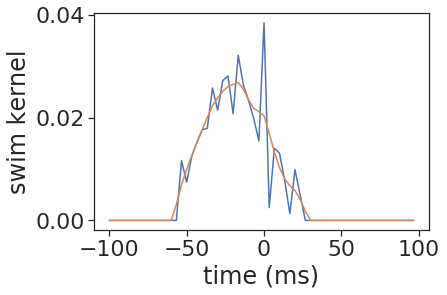

In [6]:
plt.plot(np.arange(-swim_pad,swim_pad)/300*1000, w0[spike_pad:(spike_pad+swim_pad*2)])
plt.plot(np.arange(-swim_pad,swim_pad)/300*1000, w[spike_pad:(spike_pad+swim_pad*2)])
plt.ylabel('swim kernel')
plt.xlabel('time (ms)')
plt.show()

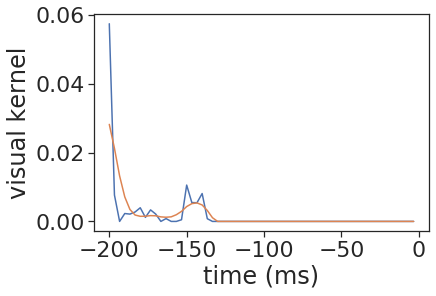

In [7]:
plt.plot(np.arange(-visu_pad,0)/300*1000, w0[(spike_pad+swim_pad*2):])
plt.plot(np.arange(-visu_pad,0)/300*1000, w[(spike_pad+swim_pad*2):])
plt.ylabel('visual kernel')
plt.xlabel('time (ms)')
plt.show()

## Get fit for all cells

In [8]:
_ = np.load('depreciated/subvolt_fit.npz', allow_pickle=True)

### cell selective type

In [40]:
comp = pd.DataFrame(_['comp_list'], columns=['swim vigor', 'visual input'])
comp = comp.replace(-1, 'inh')
comp = comp.replace(1, 'exc')
comp_table=pd.crosstab(comp['swim vigor'], comp['visual input'], margins = False)

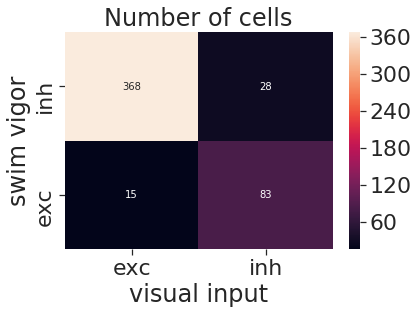

In [59]:
plt.figure()
sns.heatmap(comp_table, annot=True, fmt='d')
plt.yticks([0.5,1.5])
plt.xticks([0.5,1.5])
plt.ylim([0, 2])
plt.xlim([0, 2])
plt.title('Number of cells')
plt.show()

### Explained variance

In [93]:
comp = _['comp_list']
comp_ind = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
comp_title = ['-/-', '-/+', '+/-', '+/+']
ev_model = _['ev_model_list']*100
ev_spike = _['ev_spike_list']*100
ev_swim = _['ev_swim_list']*100
ev_visu = _['ev_visual_list']*100

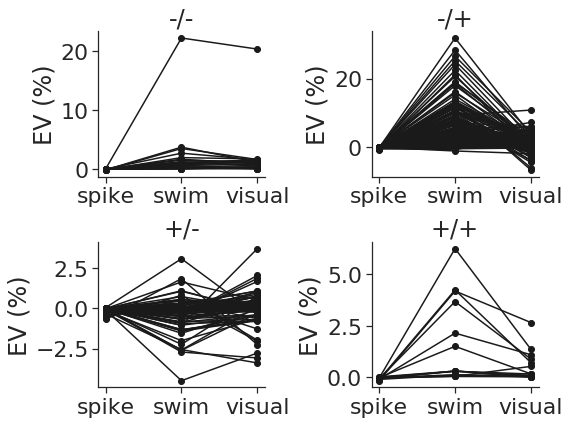

In [97]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.flatten()
for n_ in range(4):
    comp_ = comp_ind[n_]
    valid_ind = (comp==comp_).sum(axis=-1)==2
    ax[n_].plot(['spike', 'swim', 'visual'],[ev_spike[valid_ind], ev_swim[valid_ind], ev_visu[valid_ind]], '-ok')
    ax[n_].set_title(comp_title[n_])
    ax[n_].set_ylabel('EV (%)')
    sns.despine()
plt.tight_layout()
plt.show()

## Weight

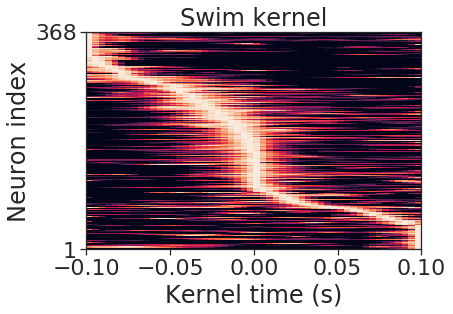

In [125]:
w_ = _['w_list']
comp_ = comp_ind[1]
valid_ind = (comp==comp_).sum(axis=-1)==2
w_swim = w_[valid_ind, (spike_pad+4):(spike_pad+swim_pad*2-4)]
w_swim_norm = w_swim/w_swim.max(axis=-1, keepdims=True)
w_ind = np.argmax(w_swim_norm, axis=-1)
w_order = np.argsort(w_ind)

plt.figure()
plt.imshow(w_swim_norm[w_order], extent=(-swim_pad/300, swim_pad/300, 1, len(w_order)), aspect='auto')
plt.yticks([1, len(w_order)])
plt.ylabel('Neuron index')
plt.xlabel('Kernel time (s)')
plt.title('Swim kernel')
plt.show()

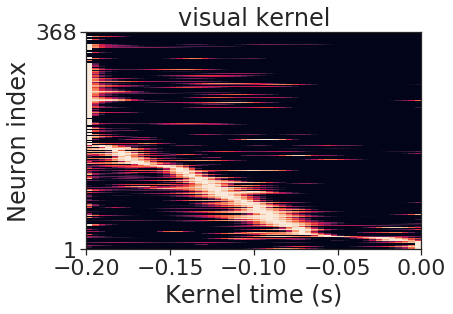

In [126]:
w_ = _['w_list']
comp_ = comp_ind[1]
valid_ind = (comp==comp_).sum(axis=-1)==2
w_visu = w_[valid_ind, (spike_pad+swim_pad*2+4):-4]
w_visu_norm = w_visu/(w_visu.max(axis=-1, keepdims=True)+0.000001)
w_ind = np.argmax(w_visu_norm, axis=-1)
w_order = np.argsort(w_ind)

plt.figure()
plt.imshow(w_visu_norm[w_order], extent=(-visu_pad/300, 0, 1, len(w_order)), aspect='auto')
plt.yticks([1, len(w_order)])
plt.ylabel('Neuron index')
plt.xlabel('Kernel time (s)')
plt.title('visual kernel')
plt.show()